**Qingbo Liu**

Spring 2020

CS 251: Data Analysis and Visualization

Project 5: Clustering

In [146]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
from scipy.stats import multivariate_normal

import kmeans
import em

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 5) EM Algorithm

### 5a) Implement multivariate Gaussian (`gaussian`)

**LA section:** Implement from scratch (i.e. using common numpy math functions and `np.linalg.det` and `np.linalg.inv`)

**Non-LA section:** Make a wrapper for Scipy stats multivariate normal pdf function.

In [3]:
# Test 1: 2D data
np.random.seed(0)
test_xy = np.random.randn(5,2)
test_mu = np.random.uniform(size=(2,))
test_sigma = np.array([[2, 1.5], [1.5, 2]])


em_test = em.EM()
gauss_pdf = em_test.gaussian(test_xy, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.06237 0.02907 0.00424 0.08301 0.08269]')

Your Gaussian PDF evaluated that the test points:
[0.06237 0.02907 0.00424 0.08301 0.08269]
It should be
[0.06237 0.02907 0.00424 0.08301 0.08269]


In [4]:
# Test 2: 4-dimensional data
np.random.seed(0)
test_10 = np.random.randn(5,4)
test_mu = np.random.uniform(size=(4,))
test_sigma = np.random.uniform(size=(4,4))
test_sigma = test_sigma.T @ test_sigma

em_test = em.EM()
gauss_pdf = em_test.gaussian(test_10, test_mu, test_sigma)
print(f'Your Gaussian PDF evaluated that the test points:\n{gauss_pdf}\nIt should be\n[0.      0.      0.      0.13288 0.     ]')

Your Gaussian PDF evaluated that the test points:
[0.      0.      0.      0.13288 0.     ]
It should be
[0.      0.      0.      0.13288 0.     ]


### 5b) Implement EM algorithm

Implement each of the following core methods in `em.py`. 

- `initialize`: Initialize cluster means, variance, and the probability that data samples belong to each of the clusters.
- `e_step`: Expectation step of EM algorithm. Compute probability each datapoint belongs to each cluster.
- `m_step`: Maximization step of EM algorithm. Compute each Gaussian cluster's mean and covariance matrix based on data assigned to each cluster.
- `log_likelihood`: Used in EM to monitor clustering progress and detect convergence. Log of sum of probabilities of all data points assigned to all clusters.
- `cluster`: Method that runs EM algorithm.

**E-Step equations:**

Compute the *responsibilities* ($w_{ci}$): the probability that data sample $i$ belongs to cluster $c$.

It can be computed in two stages: Determine $\hat{w}_{ci}$ then ${w}_{ci}$. $$\hat{w}_{ci} = \pi_c \times G\left (\mathbf{data}, \vec{\mu}_c, \mathbf{\Sigma_c}  \right )$$ Above, $\pi_c$ is the proportion of data samples that are associated with cluster $c$ (more on this below), $G(\cdot,\cdot,\cdot)$ is a multivariate Gaussian (representing cluster $c$), $\vec{\mu}_c$ is the mean (*centroid*) of that Gaussian cluster $c$, and $\mathbf{\Sigma_c}$ is the covariance matrix for cluster $c$.$${w}_{ci} = \frac{\hat{w}_{ci}}{\sum_{d=1}^{k}\hat{w}_{di}}$$


**M-Step equations:**

The job of the M-step is to compute the Gaussian cluster centroids ($\vec{\mu}_c$), Gaussian cluster covariance matrices ($\mathbf{\Sigma}_c$), and proportion of data samples that are associated each cluster ($\pi_c$).

$\pi_c$ is the average responsibility of all data samples with respect to each cluster $c$: $$\pi_c = \frac{1}{N}\sum_{j=1}^N w_{cj}$$
Note that above $N$ is the number of data samples. $$\vec{\mu}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \times \vec{\text{data}}_j $$
Above $R_c$ is defined as the sum of the responsibilities of all data samples belonging to one cluster: $R_c = \sum_{j=1}^N {w}_{cj}$.

Finally, the covariance of each cluster $\mathbf{\Sigma}_c$ is computed as: $$\mathbf{\Sigma}_c = \frac{1}{R_c} \sum_{j=1}^N w_{cj} \left ( \vec{\text{data}}_j - \vec{\mu}_c \right )^T \left ( \vec{\text{data}}_j - \vec{\mu}_c \right ) $$
where above $T$ indicates transpose.

**Log-likelihood:**

$$ll = \sum_{i=1}^N Log \left [\sum_{c=1}^k \pi_c f_c \left ( \vec{x}_i; \vec{\mu}_c, \Sigma_c \right ) \right]$$

where $f_c(\cdot)$ is the Gaussian distribution.

#### Test `e_step` (and `initialize`)

In [7]:
np.random.seed(0)

test_k = 2
test_data = np.random.randn(5,2)

em_test = em.EM(test_data)
em_test.k = test_k

em_test.initialize(test_k)
test_probs = em_test.e_step()
print(f'After 1 E step, your test responsibilities are:\n{test_probs}\nand should be:\n[[0.88106 0.11894 0.99024 0.91517 0.62642]\n\
 [0.11894 0.88106 0.00976 0.08483 0.37358]]')

After 1 E step, your test responsibilities are:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]
and should be:
[[0.88106 0.11894 0.99024 0.91517 0.62642]
 [0.11894 0.88106 0.00976 0.08483 0.37358]]


#### Test `m_step`

In [9]:
np.random.seed(0)

test_k = 2
test_data = np.random.randn(5,2)

em_test = em.EM(test_data)
em_test.k = test_k

em_test.initialize(test_k)
em_test.e_step()
test_m, test_s, test_pi = em_test.m_step()

print(f'After 1 EM iteration, your means are\n{test_m}\n')
print(f'After 1 EM iteration, your covariance matrix is\n{test_s}\n')
print(f'After 1 EM iteration, your pi array is\n{test_pi}\n')

After 1 EM iteration, your means are
[[ 1.22452 -0.06511]
 [ 0.77131  1.46643]]

After 1 EM iteration, your covariance matrix is
[[[ 0.52278 -0.22681]
  [-0.22681  0.50843]]

 [[ 0.3101   0.21107]
  [ 0.21107  0.92664]]]

After 1 EM iteration, your pi array is
[0.70637 0.29363]



The above test should output:

    After 1 EM iteration, your means are
    [[ 1.22452 -0.06511]
     [ 0.77131  1.46643]]

    After 1 EM iteration, your covariance matrix is
    [[[ 0.52278 -0.22681]
      [-0.22681  0.50843]]

     [[ 0.3101   0.21107]
      [ 0.21107  0.92664]]]

    After 1 EM iteration, your pi array is
    [0.70637 0.29363]

#### Test `log_likelihood`

In [10]:
print(f'After running 1 EM iteration (above test code), your likelihood is\n{em_test.log_likelihood()}\nand it should be\n-11.394389039914211')

After running 1 EM iteration (above test code), your likelihood is
-11.39438903991421
and it should be
-11.394389039914211


#### Test `cluster`

Use pandas to load in the `super_simple` dataset. Assign it to the variable `super_simple` then run the following test code to create a plot of your Gaussian clusters. It should look like the following image.

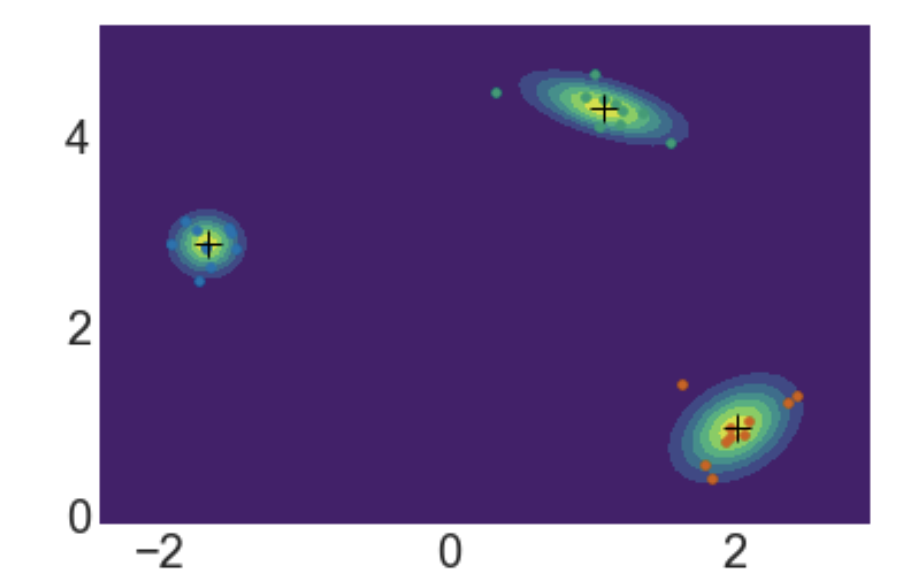

current number of iterations 1, current ll -33.55070721142693, previous ll 0, diff in ll 33.55070721142693
current number of iterations 2, current ll -23.14921909974008, previous ll -33.55070721142693, diff in ll 10.401488111686852
total number of iterations: 3


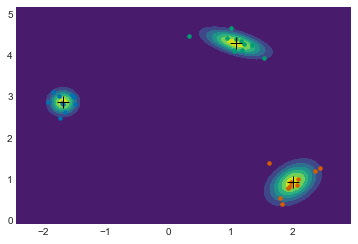

In [142]:
np.random.seed(0)

df = pd.read_csv('data/super_simple.csv')
super_simple = df.to_numpy()

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)

simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=True)
simple_test.plot_clusters(super_simple)

### 5c) EM algorithm animation visualization

- Add an optional parameter to `EM::cluster` called `animate`. By default, make it set to False.
- In the main EM loop, after performing a full iteration of EM, call the `plot_clusters` method (if `animate` is true). Immediately before your method call, add the code: `clear_output(wait=True)`. Immediately after, add the code: `plt.pause(0.1)` (The parameter, 0.1 in this case, is the wait time in seconds between plot updates in the animation).

Running this test code, should produce a (**very cool**) animation showing the EM algorithm unfolding over time. You should see if overcome a challenging initial condition.

Here is an image of what the final clustering should look like:

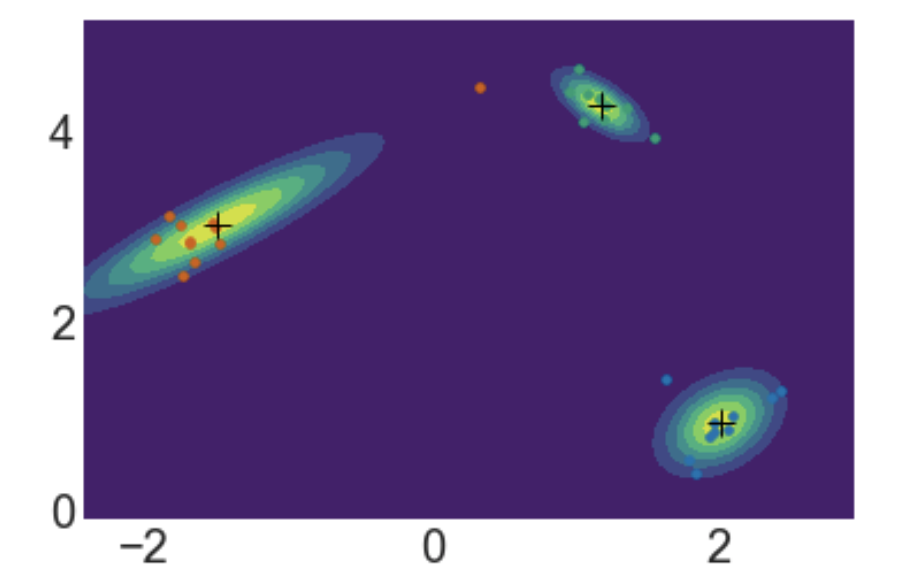

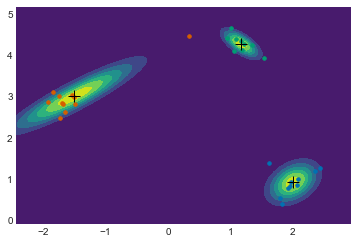

total number of iterations: 25


In [12]:
np.random.seed(4)

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)
simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, animate=True);

### 5d) Outlier detection with EM algorithm

Because the EM algorithm computes the probability that each data sample belongs to each cluster, it can be used to detect outliers in the dataset.

- Implement `find_outliers` in `em.py`.
- Run the following code to find outliers in the `super_simple` dataset (defined as samples belonging to a cluster that have probability < 0.5 here).

In [16]:
# Find outliers in all 3 clusters
outliers = simple_test.find_outliers(thres=0.5)
print(f'Sample indices of your outliers are\n{outliers}\nand they should be\n[(array([], dtype=int64),), (array([ 0, 17]),), (array([20, 26]),)]')

Sample indices of your outliers are
[array([20, 26]), array([], dtype=int64), array([ 0, 18, 28])]
and they should be
[(array([], dtype=int64),), (array([ 0, 17]),), (array([20, 26]),)]


- In the cell below, superimpose a plot on the cluster plot, indicating the outliers that you found with star markers (make them large so that they stand out). It should look like the following image:

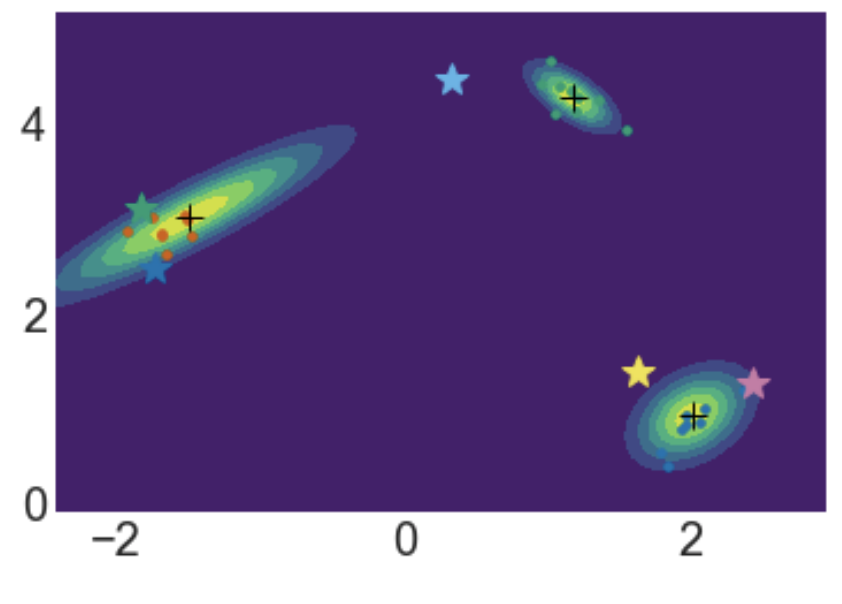

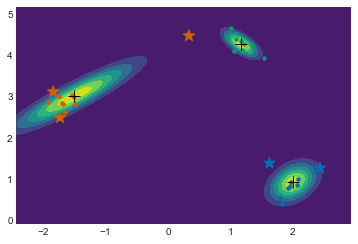

In [17]:
simple_test.plot_clusters(super_simple, show=False)

for p in outliers:
    data = simple_test.data[p]
    plt.scatter(data[:, 0], data[:, 1], marker='*', s=[150 for _ in range(len(p))])

## Task 6) Cluster a dataset of your choice with EM algorithm

- Select a 2D dataset (one we've worked with before or a new one of your choice).
    - You may select a higher dimensional dataset, but only run EM on 2 variables **that make sense (see next item)**
    - You may select a higher dimensional dataset and run PCA to reduce the dimensionality to 2D.
- Formulate a question (see question below) that could be addressed by cluster analysis.
- Import/preprocess to prepare the data for clustering by the EM algorithm.
- Analyze the data. Minimally, this should include:
    - Select a k that makes sense to you (you may explore this more rigorously as an extension).
    - Plot of the 2D data clustered.
    - Detect and show outliers
    - Report the final log likelihood of the clustering.

Below I will analyze the [e-commer](https://www.kaggle.com/carrie1/ecommerce-data) data from Kaggle that logs transactions from UK retailer. The usually approach is to cluster data based on RFM (Recency, Frequency, and Money) but because the plot function plots data on 2D plane, instead we just use recency and transaction amount to cluster the data. The RFM analysis tells us which group of customers is most valuable to us. 

First we load in the data and take a look at what it looks like. 

In [116]:
df = pd.read_csv('data/e-commerce.csv', encoding='ISO-8859-1', dtype={
    'CustomerID': str,
    'InvoiceNo': str,
})

df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


The data contains, for each transaction, the quantity and unit price of each item that a customer has purchased. But since we are only interested in the total amout of each transaction, we will first calculate the total value of each item within a single transaction and then combine them based on `InvoiceNo`. 

In [117]:
df['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [118]:
df['Value'] = df['Quantity'] * df['UnitPrice']
df['TotalValue'] = df.groupby('InvoiceNo')['Value'].transform('sum')

del df['Quantity']
del df['UnitPrice']
del df['Description']
del df['StockCode']
del df['Value']

df = df.drop_duplicates()
df.head(5)

,InvoiceNo,InvoiceDate,CustomerID,Country,TotalValue
0,536365,2010-12-01 08:26:00,17850,United Kingdom,139.12
7,536366,2010-12-01 08:28:00,17850,United Kingdom,22.20
9,536367,2010-12-01 08:34:00,13047,United Kingdom,278.73
21,536368,2010-12-01 08:34:00,13047,United Kingdom,70.05
25,536369,2010-12-01 08:35:00,13047,United Kingdom,17.85


Now that we have obtained the total value of each individual transaction, we turn to rearrange recency of the data. The basic idea is that the more recent the customer has commited a transaction, the higher the score we assign to it. To the end, we find the earliest and latest time of the transactions in our data and divide the range into five pieces, with the more recent one receiving higher score. 

In [132]:
date_min, date_max = df['InvoiceDate'].min(), df['InvoiceDate'].max()
date_interval = (date_max - date_min) / 5 

N, _ = df.shape

for i in range(N):
    d = df.iloc[i, 1]
    for j in range(5):
        lower = date_min + j * date_interval
        upper = date_min + (j+1) * date_interval
        if d >= lower and d <= upper:
            df.iloc[i, 1] = j 

        

print(f"min date {date_min}, max date {date_max}, date interval is {date_interval}")


min date 2010-12-01 08:26:00, max date 2011-12-09 12:50:00, date interval is 74 days 15:16:48


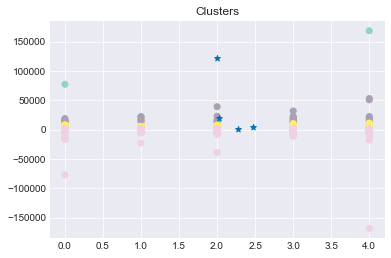

In [140]:
data = df[['InvoiceDate', 'TotalValue']].values
cluster = kmeans.KMeans(data)

cluster.cluster(k=5)
cluster.plot_clusters()

It turns out that the data is very closely clustered together due to the recency score we assign to each data point. This from a practical point of view does not yield much information. Ideally we should have at least three dimensions -- RFM -- for data clustering but due to the scope of this task, we will just end here. 

**Question 5:** What dataset did you select for clustering?

**Answer 5:** [e-commer](https://www.kaggle.com/carrie1/ecommerce-data) data from Kaggle that logs transactions from UK retailer

**Question 6:** Which two variables did you select for clustering? What question are you exploring, which you believe could be addressed by a cluster analysis?

**Answer 6:** Total value of each transaction and the recency of the transaction. The question being explored is the value of customers based on the two variables. However, because the use of discrete values for recency and the lack of a third dimension, freqency, we do not find much information from the clustering. 

**Question 7:** What is your interpretation of what the outliers that you detected mean in the context of your dataset?

**Answer 7:** The outliers in this case tell us, given the recency of the transaction, how much more the customer has spendt from the average in the group. 

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Make an `elbow_plot` for EM algorithm

- Test out and explain results of your `elbow_plot` method on a dataset.

NOTE: Log likelihood is negative and higher is better. Factor this into your interpretation.

total number of iterations: 4


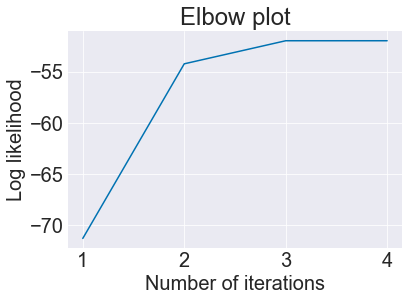

In [158]:
df = pd.read_csv('data/super_simple.csv')
super_simple = df.to_numpy()

simple_k = 3
simple_max_iter = 100

simple_test = em.EM(super_simple)

simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False)
simple_test.elbow_plot()

### 2) Better initial conditions

- EM has the same centroid initialization problem as K-means. Implement a version of K-means++ initialization for EM. Analyze the differences vs. the random initialization scheme.

While running the eblow plot above for several times, I found that random initialization to be very unstable in that sometimes it can take up to over 10 iterations for log likelihood to converge (though that plot has been covered now). Using kmeans++, I will also try to run `cluster` for several times to see how it converges. 

total number of iterations: 3


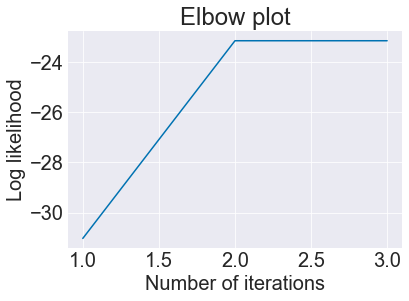

In [163]:
simple_test.cluster(k=simple_k, max_iter=simple_max_iter, verbose=False, init_method='kmeans++')
simple_test.elbow_plot()

I have manually run clustering for 5 times and each time the method will deterministically iterate for 5 times, proving the superiorty of kmeans++ over random initialization.

### 3) Image compression

- Run K-means on other images and quantify the reduction in space required to store each image (with different values of k).



Before moving on, we first discuss how k-means helps with image compression. As we did in the kmeans notebook, k-means finds k number of centroids and overwrites data in the same cluster with the centroid RGB value. The way k-means helps with image compression is that for each pixel, instead of storing its original RGB value, we can instead just store the cluster number to which the pixel belongs to. Thus given k clusters, conceptually we need to store 

$$k * (3 * 8) = 24k $$
bits for centroid RGB values and, suppose the image size is $(M, N)$, we need 

$$\text{ceil}({\text{log}_2(k)) * M * N}$$ 
bits for the whole image. 

However, for simplicity, we will use int, which is 16 bits, here to store the label for each pixel so it takes up to 

$$16 * M * N$$ 
bits for the total image. Optimizations can be applied such as bit padding to reduce the number of bits required but that is out of scope here. In the analysis for space usage, though, we will stick to the original formula.

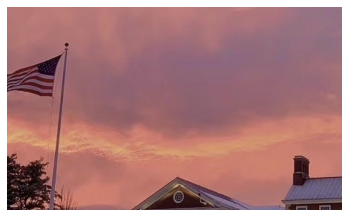

In [171]:
from matplotlib.image import imread 

img = imread('data/colby.jpeg')

fig, ax = plt.subplots()
ax.imshow(img)
ax.set_xticks([])
_ = ax.set_yticks([])

We can see that this image actually has a lot of colors and a starting point would be setting $k=16$, where $k=2^4$. In the subplots below, we respectively try $k = 16, 32, 64$. 

In [184]:
M, N, _ = img.shape

img_vec = img.reshape(M * N, 3)

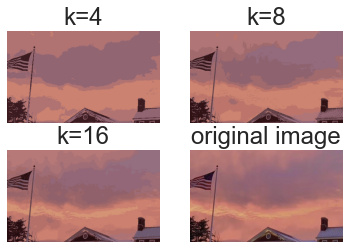

In [176]:
fig, ax = plt.subplots(nrows=2, ncols=2)
cluster = kmeans.KMeans(img_vec)

# remove ticks 
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])


cluster.cluster(k=4, init_method='kmeans++')
cluster.replace_color_with_centroid()
ax[0, 0].set_title('k=4')
ax[0, 0].imshow(cluster.data.reshape(M, N, 3))

cluster.set_data(img_vec)
cluster.cluster(k=8, init_method='kmeans++')
cluster.replace_color_with_centroid()
ax[0, 1].set_title('k=8')
ax[0, 1].imshow(cluster.data.reshape(M, N, 3))

cluster.set_data(img_vec)
cluster.cluster(k=16, init_method='kmeans++')
cluster.replace_color_with_centroid()
ax[1, 0].set_title('k=16')
ax[1, 0].imshow(cluster.data.reshape(M, N, 3))

ax[1, 1].set_title('original image')
ax[1, 1].imshow(img)

In the next plot we show the ideal size of image after kmeans compression. 

In [179]:
unique_colors = np.unique(img_vec, axis=0)
n_colors, _ = unique_colors.shape
print(f'there are in total {n_colors} unique colors and the size of image is {N*M*3*8} bits')

there are in total 18987 unique colors and the size of image is 3171864 bits


there are in total 18987 unique colors


Text(0.5, 1.0, 'Compression ratio')

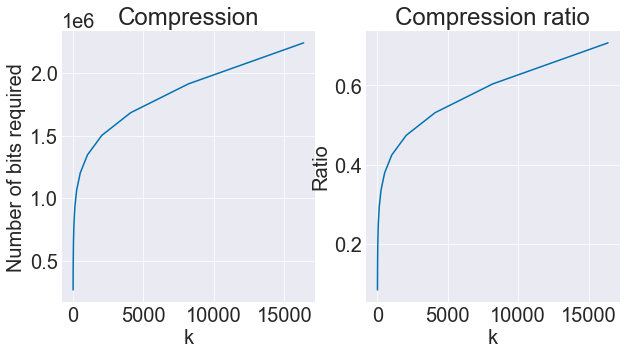

In [195]:
from math import log

total_size = N * M * 3 * 8
unique_colors = np.unique(img_vec, axis=0)
n_colors, _ = unique_colors.shape

print(f'there are in total {n_colors} unique colors')


x = []
y = []
ratio = []
base = 4 
while base < n_colors:
    x.append(base)
    centroid_size = base * 3 * 8
    image_size = N * M * (log(base)/log(2)) 
    y.append(centroid_size + image_size)
    ratio.append(y[-1]/total_size)
    
    base *= 2 

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].plot(x, y)
ax[0].set_xlabel('k')
ax[0].set_ylabel('Number of bits required')
ax[0].set_title('Compression')

ax[1].plot(x, ratio)
ax[1].set_xlabel('k')
ax[1].set_ylabel('Ratio')
ax[1].set_title('Compression ratio')

It can seen that for small values of k, the compression ratio is well below 0.2 which is very good. 


### 4) Detect number of clusters in other datasets

- Cluster other datasets and create elbow plots and/or silhouette plots to detect the number of clusters.

### 5) K-means vs. EM algorithm

- Compare the efficiency of K-means and EM. Create plots showing runtime, number of iterations, etc. Analyze / interpret the results.

### 6) Cluster additional datasets